In [1]:
!pip install plotnine networkx

In [2]:
# load autobounds components used in this demo
from autobounds.causalProblem import causalProblem
from autobounds.DAG import DAG
from autobounds.Query import Query

# load additional dependencies
import pandas as pd
import statsmodels.formula.api as smf
import plotnine as pn

# configure plotting options
pn.options.figure_size = (8, 4)

# Estimating treatment effects under noncompliance: <br>An introduction to `autobounds`

Kai Cooper, Guilherme Duarte, and Dean Knox

This notebook introduces `autobounds` (Duarte et al., 2023), a method for automatically drawing principled inferences in the presence of common imperfections in data and design. It illustrates how `autobounds` can be used to obtain sharp bounds—the narrowest possible range of conclusions consistent with available, imperfect information—using the example of a randomized experiment with noncompliance

- Section 1 introduces data from a hypothetical experiment with noncompliance, the running example in this notebook.
- Section 2 states the causal effects of interest to the analyst and describes various assumptions that analysts might use.
- Section 3 shows how to use `autobounds` to test assumptions and compute sharp bounds. 

# 1. Design and data

Suppose that a researcher designs a randomized controlled trial (RCT) that aims to estimate the causal effect of a treatment on a binary outcome. In this RCT, 1,000 subjects are randomly assigned to two treatment groups, denoted with $Z \in \{0, 1\}$. However, the RCT is affected by *noncompliance*, meaning that not all subjects obey this random assignment; let $X \in \{0, 1\}$ indicate the treatment that is actually received. Finally, a binary outcome $Y \in \{0, 1\}$ is measured.

The researcher believes that this noncompliance may be confounded with the outcome. For example, subjects that believe that the treatment will be beneficial may not comply with assignment to the control group. In an attempt to salvage the experiment, the researcher points out that assignment $Z$ can still be regarded as an *encouragement* to take treatment, suggesting an instrumental-variables analysis. 

We will first present some exploratory analyses to introduce the data.

## 1.a. Load and inspect raw data

In this subsection, we will import the data and examine some summary statistics.

In [3]:
data = pd.read_csv('/home/lisa/Documents/TUM/Semester6/thesis/non_continous/code/autobounds-main/autobounds_demo/apsa2023/data/iv_demo.csv')

In [4]:
# 1000 rows x 3 columns
data.shape

(1000, 3)

In [5]:
# examine random sample
data.sample(5)

,Z,X,Y
600,0,1.0,0.0
887,1,1.0,1.0
71,0,1.0,0.0
546,1,0.0,1.0
891,0,0.0,0.0


In [6]:
# examine 
data.mean()

Z    0.350000
X    0.641642
Y    0.473948
dtype: float64

That is, 35% of subjects were encouraged to take treatment, 64% received the treatment and 47% experienced the positive outcome.

In [7]:
# count number of units with each combination of Z, X, Y
(
    data
    .value_counts()
    .sort_values()    
)

Z  X    Y  
1  1.0  0.0     21
0  0.0  1.0     31
1  0.0  0.0     63
0  0.0  0.0     66
1  1.0  1.0     68
0  1.0  1.0    176
1  0.0  1.0    198
0  1.0  0.0    375
Name: count, dtype: int64

In [8]:
# generate informative variable names for plotting
data = data.assign(
    Z_label = data.Z.map({0 : "assigned to control", 1 : "assigned to treatment"}),
    X_label = data.X.map({0 : "received control", 1 : "received treatment"}),
    Y_label = data.Y.map({0 : "died", 1 : "survived"})
)

# create initial visualization
(
    pn.ggplot(data,
              pn.aes(x = "X_label",
                     fill = "Y_label"
                    )
             ) 
    + pn.facet_wrap("Z_label")
    + pn.geom_histogram(binwidth = 1, position = 'dodge')
    + pn.ylab("Frequency")
    + pn.theme_light()
)

TypeError: '<' not supported between instances of 'str' and 'float'

---

## 1.b. Conduct preliminary analyses

In this subsection, we will conduct a preliminary regression analysis to examine the first stage (regressing treatment uptake on encouragement) and reduced form (regressing outcome on encouragement).

In [9]:
# first stage regression
model_firststage = smf.ols("X ~ Z", data = data).fit()
model_firststage.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     541.4
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           5.35e-96
Time:                        16:26:26   Log-Likelihood:                -466.63
No. Observations:                 999   AIC:                             937.3
Df Residuals:                     997   BIC:                             947.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8505      0.015     56.074      0.000       0.821       0.880
Z             -0.5963      0.026    -23.267      0.000      -0.647      -0.546
==============================================================================
Omnibus:                       39.664   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               46.588
Skew:                          -0.439   Prob(JB):                     7.65e-11
Kurtosis:                       3.590   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This regression shows that that treatment assignment $Z$ is significantly associated with actual treatment uptake $X$, but receiving the encouragement actually *decreases* treatment uptake by 60 percentage points.

In [10]:
# first stage regression
model_reducedform = smf.ols("Y ~ Z", data = data).fit()
model_reducedform.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     214.6
Date:                Mon, 01 Jul 2024   Prob (F-statistic):           3.76e-44
Time:                        16:26:27   Log-Likelihood:                -625.62
No. Observations:                 998   AIC:                             1255.
Df Residuals:                     996   BIC:                             1265.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3194      0.018     17.936      0.000       0.284       0.354
Z              0.4406      0.030     14.649      0.000       0.382       0.500
==============================================================================
Omnibus:                      497.257   Durbin-Watson:                   2.034
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               60.544
Skew:                           0.191   Prob(JB):                     7.13e-14
Kurtosis:                       1.855   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This regression shows that that treatment assignment $Z$ significantly improves outcomes by 44 percentage points.

---

## 1.c. Prepare summary statistics

Finally, we will preprocess the data. `autobounds` works with sufficient statistics that represent the proportion of units with each unique combination of values, so we will first compute these.

In [11]:
# count units with each unique combination of Z, X, Y 
data_summary = (
    data
    .loc[:, ['Z', 'X', 'Y']]
    .value_counts()
    .rename('counts')
    .reset_index()
)
data_summary

,Z,X,Y,counts
0,0,1.0,0.0,375
1,1,0.0,1.0,198
2,0,1.0,1.0,176
3,1,1.0,1.0,68
4,0,0.0,0.0,66
5,1,0.0,0.0,63
6,0,0.0,1.0,31
7,1,1.0,0.0,21


In [12]:
# divide by the total to get the estimated probability of each type
data_summary = data_summary.assign(prob = data_summary.counts / data_summary.counts.sum())
data_summary

,Z,X,Y,counts,prob
0,0,1.0,0.0,375,0.375752
1,1,0.0,1.0,198,0.198397
2,0,1.0,1.0,176,0.176353
3,1,1.0,1.0,68,0.068136
4,0,0.0,0.0,66,0.066132
5,1,0.0,0.0,63,0.063126
6,0,0.0,1.0,31,0.031062
7,1,1.0,0.0,21,0.021042


---

# 2. Background, assumptions, and estimands

In this section, we provide brief background on the instrumental variables model, as well as a discussion of common assumptions and estimands.

## 2.a. Background on instrumental variables in the context of `autobounds`

Imbens and Angrist (1994) show that in terms of subjects' decisions to take treatment, the population can divided into four mutually exclusive groups. Note that membership in these groups cannot be directly observed.

* **Never-takers:** those that will never take treatment regardless of encouragement, i.e. subjects with $X(Z=0)=0$ and $X(Z=1)=0$
* **Compliers:** those that will only take treatment when encouraged, i.e. subjects with $X(Z=0)=0$ and $X(Z=1)=1$
* **Defiers:** those that will only take treatment when *not* encouraged, i.e. subjects with $X(Z=0)=1$ and $X(Z=1)=0$
* **Always-takers:** those that will never take treatment regardless of encouragement, i.e. subjects with $X(Z=0)=1$ and $X(Z=1)=1$

---

## 2.b. Common assumptions in instrumental-variables analysis

Imbens and Angrist (1994) discuss a number of assumptions for the instrumental variables problems. For our purposes, the most important are:

- **Unconfoundedness:** Encouragement $Z$ is not confounded with treatment uptake $X$ or outcome $Y$. Formally, this states that $Z$ is independent of $X(z)$ for any $z$ and $Y(x)$ for any $x$.
- **Exclusion restriction:** Encouragement $Z$ does not directly affect outcome $Y$ except through treatment uptake $X$. Formally, this states that $Y(z,x)$ is the same as $Y(x)$ for all $z$ and $x$.
- **Monotonicity:** There are no "defier" subjects, as defined above. Formally, this states that $X(Z=1) \ge X(Z=0)$.

Applied researchers often make all of the above assumptions without considering whether they are substantively justified in a particular setting.

However, the assumptions often do not hold. In the running example, only the unconfoundedness assumption is guaranteed by the experimental design, because $Z$ is randomized.

---

## 2.c. Common estimands in instrumental-variables analyses

Most applied research seeks to identify an average treatment effect (ATE), averaging over all subjects or the population from which those subjects were drawn. Formally, the ATE is $\mathbb{E}[Y(X=1) - Y(X=0)]$.

Unfortunately, this quantity cannot be precisely estimated when there is noncompliance with treatment assignment. One intuitive reason for this is because the behavior of never-takers and always-takers is unaffected by the randomized encouragement. Therefore, the effect of treatment is fundamentally unidentifiable in these groups.

If all of the above assumptions are in fact true (and if the encouragement does in fact affect treatment uptake), Imbens and Angrist (1994) show that a particular causal effect—the *local* average treatment effect (LATE) among the subgroup of compliers—can be identified using the conventional two-stage least squares estimator. Formally, the LATE is $\mathbb{E}[Y(X=1) - Y(X=0) | X(Z=0)=0, X(Z=1)=1]$.

Because the ATE generally cannot be point identified under noncompliance, it is common for applied researchers to behave as if they are uninterested in this quantity. Often, researchers claim that the purpose of the experiment was to identify the LATE instead. However, the LATE is rarely of practical importance, because  whether subjects comply with an encouragement often depends on how that encouragement was implemented in the context of a particular experiment. Moreover, LATE also cannot be point identified unless all of the assumptions described above are satisfied.

Below, we will show how `autobounds` allows researchers to compute *sharp bounds*, or the narrowest possible range of conclusions that honestly acknowledge limitations and use only the assumptions that are substantively defensible, for essentially any estimand including the ATE and LATE. We will also show how `autobounds` checks assumptions and alert researchers when their observable implications are violated.

---

# 3. Computation of effects via `autobounds`

In this section, we demonstrate the use of `autobounds`. First, we demonstrate how to compute sharp bounds on the original quantity of interest, the ATE, using only assumptions that are substantively justified. Next, we show how researchers can also target the LATE by simply declaring a different estimand. Finally, we illustrate how `autobounds` can detect violations of assumptions that would be missed by traditional methods.

## 3.a. Bounding the ATE under plausible assumptions

In this section, we will present a step-by-step demonstration of `autobounds`. As a working example, we will compute sharp bounds on the original quantity of interest, the ATE, under only the assumptions that make sense in this setting: unconfoundedness and the exclusion restriction. 

First, we will define the assumed directed acyclic graph (DAG). All of the plausible assumptions in this case are structural assumptions that can be represented in this graph. Instatiate an empty DAG via the `DAG` class within the package. Build the structure of the graph with the method `.from_structure()`, which takes two arguments: 
- `edges`: A comma-separated string listing pairs of connected nodes. E.g. `"A -> B, B -> C, U -> A, U -> B"`
- `unob`: A comma-separated string listing the nodes that are unobserved disturbances

The graph can then be visualized using its `.plot()` method.

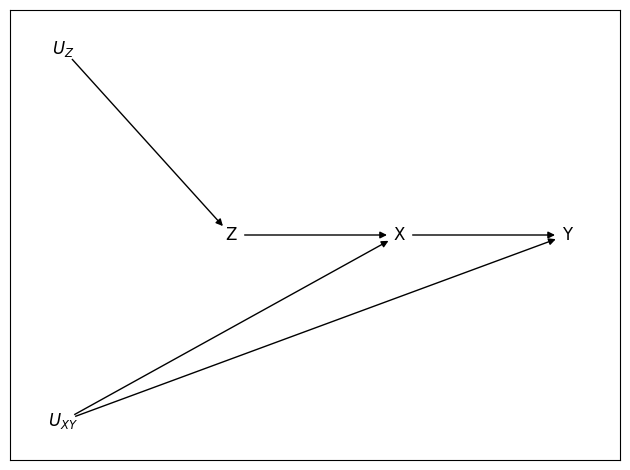

In [13]:
# first initialize an empty graph
graph = DAG()

# define edges and unobserved disturbances
graph.from_structure(
    edges = "Uz -> Z, Z -> X, X -> Y, Uxy -> X, Uxy -> Y",
    unob = "Uz, Uxy"
)

# visualize the graph
graph.plot()

Second, we will tell `autobounds` about the causal-inference problem we would like to solve. A problem is defined by four elements:
- The causal graph, or structural assumptions relating the variables
- The sample space, or the number of unique values that each variable can take on
- Additional functional-form assumptions justified by domain expertise
- The empirical evidence, or the data
- The quantity of interest, or the estimand

We will begin with the `causalProblem()` constructor, which takes two arguments:
- `graph`: the causal structure that the problem involves
- `number_values` (optional): a dictionary in which keys are variable names and values are variable cardinalities (binary, ternary, etc.). E.g. `"{A : 2, B: 3}`. If left unspecified, all variables are assumed to be binary.

In [14]:
# initialize a causal-inference problem involving the iv dag
problem = causalProblem(
    graph,
    number_values = {"Z" : 2, "X" : 2, "Y" : 2}  # for illustration (not needed, same as defaults)
)

After initializing this problem, we next add the assumptions that `autobounds` should use.

This includes additional non-structural assumptions like monotonicity, which can be added with the `.add_constraint()` method. In this case, the monotonicity assumption makes little sense, so we will omit it for now. Later, we will show how to add and test this assumption.

Currently, we also need to tell `autobounds` about the laws of probability. This is done with the `.add_prob_constraints()` method.

In [15]:
# if we had functional-form assumptions such as monotonicity, they would be entered here
# problem.add_constraint(...)

# tell autobounds about the laws of probability
# (in a future update this will be handled automatically)
problem.add_prob_constraints()

The next step is to tell `autobounds` about the empirical evidence. The `.load_data()` method accepts summary statistics in the form of a `pandas` `DataFrame` object or a path to a CSV file. Regardless of the input format, this must contain (i) one column per variable measured in the dataset, (ii) one row per unique combination of values, and (iii) an additional column named "prob" indicating the proportion of units of this type. An example is given in `data_summary` above.

In [16]:
# load in the data
problem.load_data(data_summary)

The last step is to define the quantity of interest: the ATE of actually receiving treatment $X$ on outcome $Y$. Below, two arguments are provided to the `.set_ate()` method:
- `ind`: the name of the independent variable, or treatment
- `dep`: the name of the dependent variable, or outcome

There are more complex ways to define estimands, some of which will be illustrated later.

In [17]:
problem.set_ate(ind = "X", dep = "Y")

Finally, we are ready to compute bounds. To do so, we will first translate the completely specified causal-inference problem into an equivalent *optimization program*. Solving this program with a numeric optimizer (like SCIP in the example below) will produce the desired sharp bounds.

In [18]:
# translate causal inference problem into optimization program
program = problem.write_program()

# run optimisation routine, argument saves results at filename
results = program.run_scip()

# examine complete output
# - "dual" bounds are guaranteed-valid causal bounds on the estimand
# - "primal" bounds are used to evaluate the sharpness of those bounds
# when the duals are equal to the primals, the reported bounds are perfectly sharp
# for more details, including the interpretation of theta and epsilon, see Duarte et al (2023)
results

({'primal': 0.271604938271605,
  'dual': 0.271604938271605,
  'time': 0.0,
  'end': 1},
 {'primal': 0.421296296296296,
  'dual': 0.421296296296296,
  'time': 0.0,
  'end': 1},
 0.14969135802469102,
 0.0)

In [19]:
"Based on these data and assumptions, the ATE is in the range [{lower:0.3f}, {upper:0.3f}]".format(
    lower = results[0]["dual"],  # index [0] selects lower bound, key ["dual"] selects guaranteed-valid bound
    upper = results[1]["dual"],  # index [1] selects upper bound, key ["dual"] selects guaranteed-valid bound
)

'Based on these data and assumptions, the ATE is in the range [0.272, 0.421]'

In other words, based on assumptions that are highly plausible, analysts can determine that the effect of the treatment is strongly negative despite severe noncompliance in the study.

---

## 3.b. Bounding the LATE under plausible assumptions

What if we are actually interested in the LATE among compliers after all? `autobounds` is modular and simple to use: to bound this quantity, we can simply reuse the same code but state a different estimand: the *conditional* effect among compliers, or subjects with $X(Z=0)=0$ and $X(Z=1)=1$. 

In [20]:
# initialize a causal-inference problem involving the iv dag
problem_late = causalProblem(graph)

# tell autobounds about the laws of probability
# (in a future update this will be handled automatically)
problem_late.add_prob_constraints()

# load in the data
problem_late.load_data(data_summary)

# we now target the conditional ate among compliers  <-- THIS IS THE ONLY LINE THAT DIFFERS FROM 3.A
problem_late.set_ate(ind = "X", dep = "Y", cond = "X(Z=0)=0 & X(Z=1)=1")

# translate causal inference problem into optimization program
program_late = problem_late.write_program()

# run optimisation routine, argument saves results at filename
results_late = program_late.run_scip()

"Based on these data and assumptions, the ATE is in the range [{lower:0.3f}, {upper:0.3f}]".format(
    lower = results_late[0]["dual"],  # index [0] corresponds to lower bound, dual is the guaranteed-valid bound
    upper = results_late[1]["dual"],  # index [1] corresponds to lower bound, dual is the guaranteed-valid bound
)

'Based on these data and assumptions, the ATE is in the range [-0.000, 1.000]'

In other words, the experiment is completely uninformative about the LATE: the bounds cover the entire region of possible values, from $-1$ to $1$! (Note that the bounds computed above are slightly wider due to default numeric tolerance settings that can be adjusted.)

Intuitively, this is because there is no way to determine who the compliers are, or even how large the complier group is, without additional assumptions. To identify the size of the complier group, an additional monotonicity assumption is needed.

---

## 3.c. Testing observable implications of your theory

What happens if analysts make a bad assumption? Here, we will illustrate how `autobounds` tests all observable implications of your assumed theory—both structural and functional assumptions—and alerts analysts to violations. 

To do so, we will impose the monotonicity assumption that is commonly used in instrumental-variables analyses, despite the fact that it makes little sense in this context.

In [21]:
# initialize a causal-inference problem involving the iv dag
problem_badtheory = causalProblem(graph)

# tell autobounds about the laws of probability
# (in a future update this will be handled automatically)
problem_badtheory.add_prob_constraints()

# add the monotonicity assumption  <-- THIS IS THE ONLY LINE THAT DIFFERS FROM 3.A
# by default, .add_constraint() makes the size of the stated group equal to zero 
defiers = problem_badtheory.query("X(Z=0)=1 & X(Z=1)=0")
problem_badtheory.add_constraint(defiers) # pr(defiers) == 0

# load in the data
problem_badtheory.load_data(data_summary)

# we will target the unconditional ate for illustration; targeting the late produces the same result
problem_badtheory.set_ate(ind = "X", dep = "Y")

# translate causal inference problem into optimization program
program_badtheory = problem_badtheory.write_program()

# run optimisation routine, argument saves results at filename
results_badtheory = program_badtheory.run_scip()

This problem is *infeasible*, meaning that `autobounds` cannot find any data-generating processes that are consistent with both the stated assumptions and the empirical evidence. This means that the observable implications of the assumptions are violated. In other words, `autobounds` can prevent researchers from making claims based on demonstrably false premises!

# References

Guilherme Duarte, Noam Finkelstein, Dean Knox, Jonathan Mummolo, and Ilya Shpitser. 2023. "An Automated Approach to Causal Inference in Discrete Settings," *Journal of the American Statistical Association* (Theory and Methods). https://doi.org/10.1080/01621459.2023.2216909

Guido Imbens and Joshua Angrist. 1994. "Identification and Estimation of Local Average Treatment Effects," *Econometrica* https://doi.org/10.2307/2951620
